# Demonstration of Messenger Method Code Within mod_mess.py

The messenger method is a method devised by Elsner and Wandelt in 2012 (https://arxiv.org/pdf/1210.4931.pdf). This code implements this method in order to solve for a pure B mode map from input CMB data. The input data to this filter is a set of three maps corresponding to Stoke's parameters I, Q, and U. The output is a filtered set of these same three maps. This code relies heavily on the healpy package. Everything about healpy can be found here: https://healpy.readthedocs.io/en/latest/

In [2]:
cd /Users/Michaelray/Documents/Bischoff Research/Messenger Method/messenger_method

/Users/Michaelray/Documents/Bischoff Research/Messenger Method/messenger_method


In [3]:
import mod_mess as mm
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import time

To use the filter, we need a noise covariance object, a signal covariance object, and a cooling schedule. The cooling schedule controls a scalable parameter lambda within the filter whose purpose is to speed up convergence of the filter. Below we set up these three objects.

First we set up the noise covariance object with an Nside of 512. The Nside value just controls how large the noise covariance object will be. This Nside must be consistent with the size of the signal covariance matrix, or else the program will throw an error when we get to the filtering portion. Once we set up the object, we will create the noise covariance matrix by taking it to be diagonal with two copies of 1/mask being the diagonal entries. The reason we take two copies of 1/mask is because the noise covariance matrix must match the size of the signal covariance matrix, which has both an E and B mode component. So we are saying that the noise covariance for the B mode portion is 1/mask and also the noise covariance for the E mode portion is 1/mask. The mask here is shown below using a Mollweide projection. You will notice that we set all of the nan values in the mask to be 1e-10. This is simply because setting them to identically zero causes issues when we take the inverse and then try to use the noise covariance matrix to do computations. So, we just set it to a value so small that our filter won't know the difference between this value and zero.

Before we do anything, however, we'll set up the parameters Nside, Npix, Nsph and ellmax. These have to do with the resolution of our map and setting them up at the very start ensures that everything will be consistent throughout the code so that we don't run into trouble somewhere down the line when the sizes of some objects don't match up.

In [4]:
Nside = 512
Npix = 12*Nside**2
Ellmax = 3*Nside-1
Nsph = int(np.sum(1.0 * np.arange(Ellmax+1) + 1.0))

In [5]:
N_cov = mm.Noise_cov(Nside=Nside)

mask = hp.read_map('512.fits')
mask[np.where(np.isnan(mask))] = 1e-10
Ndiag = np.concatenate((mask**(-1), mask**(-1)),axis=0)

N_cov.make_matrix(matrix = Ndiag)

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/Users/Michaelray/opt/anaconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:372: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))
/Users/Michaelray/opt/anaconda3/lib/python3.7/site-packages/healpy/pixelfunc.py:345: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)


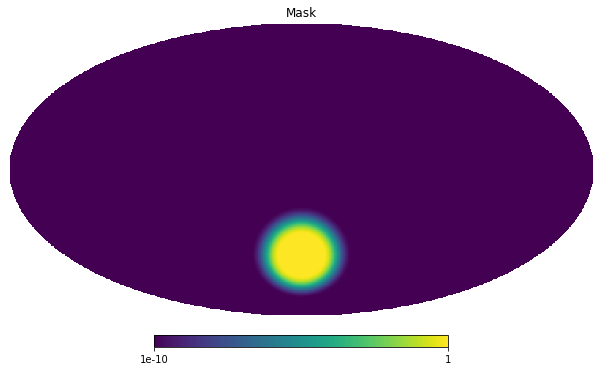

In [6]:
hp.mollview(mask, title='Mask')

Just to make sure everything is working as it should, let's check that our noise covariance matrix is diagonal. This should be the case because we put in an object of size Npix (rather than Npix squared, which would indicate a non-diagonal matrix).

In [7]:
N_cov.is_diagonal

True

We will now set up the signal covariance matrix. This will be done by using the power spectra we expect to see based on theoretical calculations (with no primordial gravitational waves). So our signal covariance consists of a B-mode signal that is expected if inflation did not, in fact, occur in the early universe. The E-mode part of the signal covariance is set to zero (because we want a pure-B filter). Let's first load in the theoretical power spectra and take a look at them.

In [10]:
dls = np.genfromtxt("/Users/Michaelray/Documents/Bischoff Research/Messenger Method/ffp10_lensedCls.dat")
dls = np.insert(dls, [0], [1,0,0,0,0], axis = 0)
dls = np.insert(dls, [0], [0,0,0,0,0], axis = 0)
d_ell = np.array([dls[:,0]])
d_spectra = dls[:,1:]
Cls = np.array([d_spectra[i]*2*np.pi/(i * (i+1)) for i in range(len(d_spectra))])
c_ells = np.concatenate((np.transpose(d_ell), Cls), axis = 1)
c_ells_t = np.transpose(c_ells)
B_pspec = c_ells_t[3, :1535]

/Users/Michaelray/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


Text(0, 0.5, '$C_{\\ell}$ ($\\mu K^2$)')

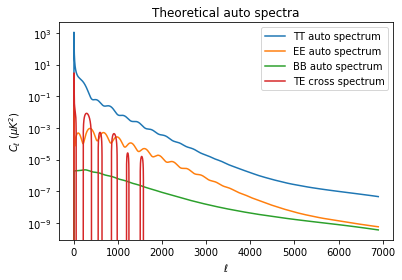

In [11]:
plt.semilogy(c_ells_t[1,:], label='TT auto spectrum')
plt.semilogy(c_ells_t[2,:], label='EE auto spectrum')
plt.semilogy(c_ells_t[3,:], label='BB auto spectrum')
plt.semilogy(c_ells_t[4,:], label='TE cross spectrum')
plt.legend()
plt.title('Theoretical auto spectra')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\ell}$ ($\mu K^2$)')

Now let's use the BB auto spectra to create our signal covariance matrix. The signal covariance object in our case is diagonal, with the diagonal values being the BB spectrum expanded out to be the number of spherical harmonic coefficients present in our data. In our case, we will just take the first 1536 values in the BB spectrum (because this number is consistent with the resolution our data). We will then use the function hp.almxfl to expand the spectrum out to its corresponding spherical harmonic coefficients. The choice of spherical harmonic coefficients here are not unique because going from spherical harmonic coefficients to a power spectrum involves taking an average. Thus going from a power spectrum to spherical harmonic coefficients just means creating a set of coefficients such that the m values, when taking the absolute square of them, average to the power spectrum.

Another thing to note is that we have applied a beam to our theoretical power spectrum. This is because when we actually take data, we have to account for a beam which smooths out our data. The intuitive way to think about this is that we don't have perfect resolution in our measurements, so the data we actually get out is an average over measurements that are close together on the sky. In this case, we have used a beam with size (full width half maximum) of 24.2 arcminutes. This is then used to create a gaussian function which smooths the spectrum as described above.

In [12]:
FWHM = 24.2
sigma_rad = (FWHM/(np.sqrt(8*np.log(2))))*(np.pi/(60*180))
ells = np.arange(Ellmax)
B_ell_squared = np.e**((-1)*(ells**2)*(sigma_rad**2))
B_pspec[:30]=1e-10
B_pspec_beamed = B_pspec*B_ell_squared
B_cov = hp.almxfl(np.ones(Nsph), B_pspec_beamed)
S_B = np.concatenate((np.zeros(Nsph), B_cov), axis = 0)

S_cov = mm.Sig_cov()
S_cov.make_matrix(matrix = S_B)

Just as with the noise covariance matrix, the signal covariance matrix should be diagonal because we put in an object of size Nsph rather than Nsph squared, which would indicate a non-diagonal matrix. Let's check that this is correct.

In [13]:
S_cov.is_diagonal

True

We've now got our signal and noise covariance objects. We still need a cooling schedule for this code to work. The cooling schedule has to do with how the lambda value in the messenger method is decreased. The final value of the cooling schedule must be one, because only when lambda is one do the messenger method equations reduce to a true wiener filter (filter which minimizes chi-squared). Built-in options for the cooling schedule are standard_cooling or linear_lam. 

standard_cooling begins with a lambda value of 1300, then bumps lambda down to 100, then multiplies lambda by some factor eta (set by default to 0.7 but that can be adjusted) on each iteration until lambda falls below 1, at which point we tack on the value 1 to the lambda list five times. So the lambda value in the iteration goes as follows: 1300, 100, 100 * eta, 100 * eta^2, 100 * eta^3, ...., 1, 1, 1, 1, 1. Various cooling schedules were played around with when this code was being written and this one seemed to work the best in the cases we were interested in.

The linear_lam option begins at some specified lambda (adjustable in the function), and then decreases lambda by some set value on each iteration until it falls below 1, at which point we tack on the value 1 to our lambda list. 

The custom cooling schedule just works by taking in a list of lambda values and converting it to a numpy array. If you use the custom cooling schedule remember that it is imperative that the final value is 1. If it is not, then the messenger method does not reduce to a wiener filter.

We will work with the standard_cooling cooling schedule for this demonstration.

In [14]:
Cooling = mm.Cooling()
Cooling.lam_list = Cooling.standard_cooling(eta=0.7)

Now we are ready to create our messenger method wiener filter object.

In [15]:
mmwf = mm.Mmwf(N_cov = N_cov, Sig_cov = S_cov, Cooling = Cooling)

So our filter is now ready to take in data. This filter object can now be thought of as a black box where we input data and we get B-mode only data out. Let's try using this on some data. First we'll create a map of B-mode only input by using hp.synfast and giving it only a BB power spectrum. Then we'll see what happens when we give it an E-mode only input. Remember that this is a B-mode only filter so we should see that when we send in an E-mode only map, we get back very small output when compared to when we give it a B-mode only input. These maps will be masked so that they mimic actual measured data. Once we look at these, we will look at what happens when we give the filter realistic data, by creating a map that has E-modes and B-modes. First let's make a B-mode only map. Synfast will give us a list of 3 maps which correspond to Stoke's parameters I, Q, and U. For polarization purposes, we usually only care about the Q and U maps but the I map will come along for the ride.

In [27]:
bmaps = hp.synfast(cls = (np.zeros(Ellmax), np.zeros(Ellmax), c_ells_t[3,:1535], np.zeros(Ellmax)), nside=Nside, new=True)
bmaps = bmaps*mask

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


Let's take a look at this B-mode only map.

In [28]:
np.shape(bmaps)

(3, 3145728)

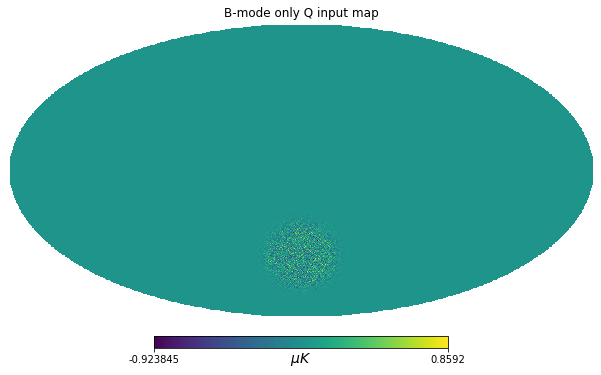

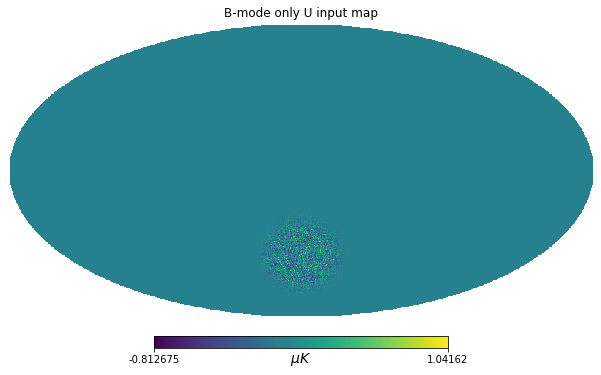

In [18]:
hp.mollview(bmaps[1,:], title='B-mode only Q input map', unit = '$\mu K$')
hp.mollview(bmaps[2,:], title='B-mode only U input map', unit = '$\mu K$')

We can get a better look at these maps by zooming in on the unmasked region using hp.gnomview.

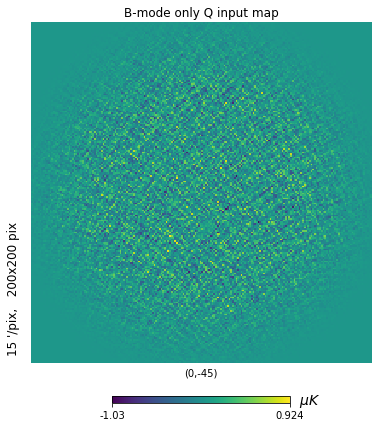

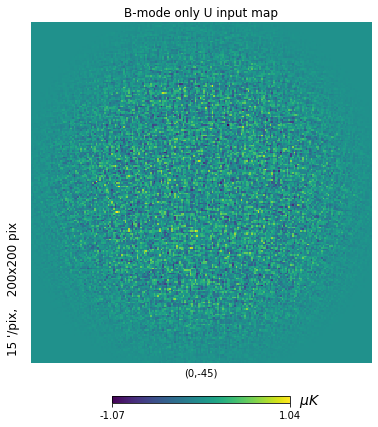

In [19]:
hp.gnomview(bmaps[1,:], title='B-mode only Q input map', unit = '$\mu K$', reso=15, rot=(0, -45))
hp.gnomview(bmaps[2,:], title='B-mode only U input map', unit = '$\mu K$', reso=15, rot=(0, -45))

We can visually see (although it takes a bit of a trained eye to see this) that we have B-modes here because the Q maps looks like it has diagonal lines running across it and the U map has vertical/horizontal lines running across it. Now let's see what happens when we filter these maps.

In [26]:
start_time = time.clock()
out_balms = mmwf.filter_map_pureB(data = bmaps)
computation_time = time.clock() - start_time
print("Computation time (seconds) = ", computation_time)

/Users/Michaelray/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


KeyboardInterrupt: 

In [25]:
print(np.shape(out_balms))
print(Nsph*2)

(2360832,)
2360832


As can be seen above, the size of our output maps is the same as Nsph * 2. Our output is the spherical harmonic coefficients for E and B modes. At the end of our iterative scheme, however, we explicitly project out the E-mode components. So the first Nsph entries in the filtered_maps object are all zeros. The last Nsph are what we actually care about. These are the B-mode spherical harmonic coefficients. Let's turn these into I, Q, and U maps so we can look at them.

In [29]:
balms = np.array([np.zeros(Nsph), out_balms[:Nsph], out_balms[Nsph:]])
filtered_bmaps = hp.alm2map(balms, nside=Nside, lmax=Ellmax, pol=True)

NameError: name 'out_balms' is not defined